In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import time
from argparse import Namespace

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style("whitegrid")

from src.plotting_utils import (
    get_last_exp_by_time,
    add_question_idx_in_dataset,
    probability_stats,
    RANDOM_PERFORMANCE,
    DATASET_NAMES,
    LEVEL_COLORS,
    MODEL_NAMES,
)
from src.utils import load_pickle
from src.dataset_utils import get_dataset
from src.definitions import LEVELS
from src.metrics import (
    get_instuction_following_percentage,
    get_sample_metrics,
    get_metrics,
)
from src.arguments import get_advocate_data_folder
import matplotlib.patches as mpatches

data_path = "euler_logs/logs_18_03"
model_advocate = "Llama-2-70b-chat"
models = ["Llama-2-70b-chat", "Mixtral", "falcon-40b"]

model_colors = ["#293e9f", "#88abfd", "#df431d"]


datasets = [
    "piqa",
    "siqa",
    "commonsense_qa",
    "openbookqa",
    "wiki_qa",
    "gpqa",
    "quality",
    "boolq",
]

In [4]:
# First let us calculate the random performance for each dataset
CALCULATE_STATS = False

if CALCULATE_STATS:
    results = {}
    for dataset_name in datasets:
        dataset, choices, base_answer = get_dataset(
            Namespace(base_data_folder="./data"),
            dataset_name,
            None,
            system_prompt="",
            is_advocate=False,
            num_samples=None,
            advocate_level="None",
            advocate_file=None,
            include_explanation=False,
        )

        results[dataset_name] = np.mean(
            [
                len(dataset[i]["correct_answers_idx"])
                / (
                    len(dataset[i]["correct_answers_idx"])
                    + len(dataset[i]["wrong_answers_idx"])
                )
                for i in range(len(dataset))
            ]
        )

    print(results)

## First let us check the instruction following

In [5]:
judge_level = "assistant"
advocate_level = "assistant"
additional_syste_prompt = "None"

results = []

for dataset_name in datasets:
    for model in models:
        # Load the data
        exp = get_last_exp_by_time(
            data_path, model, dataset_name, additional_syste_prompt
        )

        for include_explanation in [False, True]:
            prob_filename = f"probabilities_{judge_level}_{advocate_level}_{include_explanation}.pkl"
            probabilities = load_pickle(os.path.join(exp, prob_filename))

            dataset_filename = (
                f"dataset_{judge_level}_{advocate_level}_{include_explanation}.pkl"
            )
            dataset = load_pickle(os.path.join(exp, dataset_filename))

            results.append(
                {
                    "dataset": dataset_name,
                    "model": model,
                    "include_explanation": include_explanation,
                    "instuction_following_percentage": get_instuction_following_percentage(
                        dataset, probabilities
                    ).mean(),
                    "performace": get_metrics(advocate_level, probabilities, dataset),
                }
            )

/local/home/sanagnos/miniconda3/envs/transformers/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/local/home/sanagnos/miniconda3/envs/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


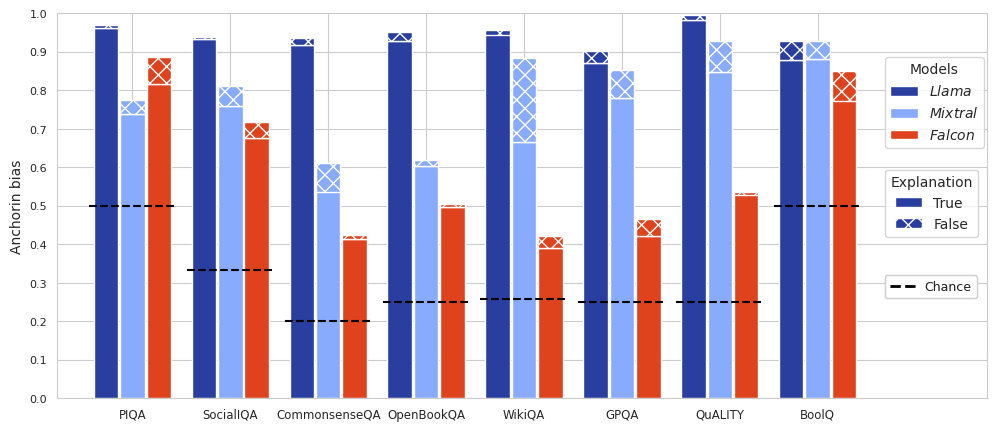

In [6]:
from src.plotting_utils import DATASET_NAMES

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)

x_points = np.arange(len(datasets))
total_width = 0.75
spacing = 0.02
width = total_width / len(models)

for i, model in enumerate(models):
    y_points_True = np.array(
        [
            res["instuction_following_percentage"]
            for res in results
            if res["model"] == model and res["include_explanation"] == True
        ]
    )
    ax.bar(
        x_points + i * width + i * spacing,
        y_points_True,
        width=width,
        label=model,
        color=model_colors[i],
        zorder=5,
    )

    # plot on top of the bar
    y_points_False = np.array(
        [
            res["instuction_following_percentage"]
            for res in results
            if res["model"] == model and res["include_explanation"] == False
        ]
    )

    ax.bar(
        x_points + i * width + i * spacing,
        y_points_False - y_points_True,
        width=width,
        label=model,
        bottom=y_points_True,
        color=model_colors[i],
        hatch="XX",
        zorder=5,
    )

for i, dataset_name in enumerate(datasets):
    # plots random prediction like
    ax.plot(
        [i - width / 2 - 0.05, i + total_width - width / 2 + 0.08],
        [RANDOM_PERFORMANCE[dataset_name], RANDOM_PERFORMANCE[dataset_name]],
        color="black",
        linestyle="--",
        zorder=10,
    )

ax.set_xlim([-0.5, len(datasets) + 1])
ax.set_xticks(
    x_points + np.mean([i * (width + spacing) for i in range(len(models))]),
    [DATASET_NAMES[dataset_name] for dataset_name in datasets],
    rotation=0,
    fontsize=8.5,
)
ax.set_yticks(
    np.arange(0, 1.1, 0.1),
    ["{:.1f}".format(x) for x in np.arange(0, 1.1, 0.1)],
    fontsize=8,
)
ax.set_ylabel("Anchorin bias")

legend_lines = [mpatches.Patch(facecolor=color, alpha=1) for color in model_colors]
legend_names = [MODEL_NAMES[model] for model in models]
legend = plt.legend(
    legend_lines, legend_names, loc=(0.89, 0.65), ncol=1, fontsize=10, title="Models"
)
ax.add_artist(legend)

legend_lines = [
    mpatches.Patch(facecolor=model_colors[0], alpha=1, hatch=hatch)
    for hatch in [None, "XX"]
]
legend_names = ["True", "False"]
legend = plt.legend(
    legend_lines,
    legend_names,
    loc=(0.89, 0.42),
    ncol=1,
    fontsize=10,
    title="Explanation",
)
ax.add_artist(legend)

legend = plt.legend(
    [plt.Line2D([0], [0], color="black", ls="--", alpha=1, lw=2)],
    ["Chance"],
    loc=(0.89, 0.26),
    ncol=1,
    fontsize=9,
)
ax.add_artist(legend)
ax.set_ylim([0, 1])
plt.savefig("figures/instuction_following_percentage.pdf")
plt.show()

## Get performance

In [455]:
judge_level = "assistant"
additional_syste_prompt = "None"

results_advocate = []

for dataset_name in datasets:
    for model in models:
        # Load the data
        exp = get_last_exp_by_time(
            data_path, model, dataset_name, additional_syste_prompt
        )
        for advocate_level, include_explanation in zip(
            ["None", "assistant", "assistant"], [False, False, True]
        ):
            prob_filename = f"probabilities_{judge_level}_{advocate_level}_{include_explanation}.pkl"
            probabilities = load_pickle(os.path.join(exp, prob_filename))

            dataset_filename = (
                f"dataset_{judge_level}_{advocate_level}_{include_explanation}.pkl"
            )
            dataset = load_pickle(os.path.join(exp, dataset_filename))

            results_advocate.append(
                {
                    "dataset": dataset_name,
                    "model": model,
                    "include_explanation": include_explanation,
                    "instuction_following_percentage": get_instuction_following_percentage(
                        dataset, probabilities
                    ).mean()
                    if advocate_level != "None"
                    else None,
                    "advocate_level": advocate_level,
                    "performance": get_metrics(advocate_level, probabilities, dataset),
                }
            )

/local/home/sanagnos/miniconda3/envs/transformers/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/local/home/sanagnos/miniconda3/envs/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


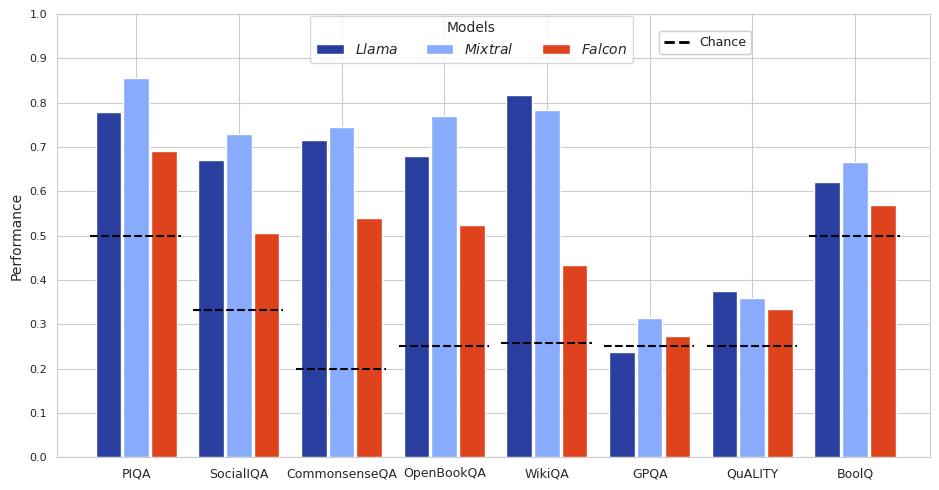

In [511]:
fig = plt.figure(figsize=(9.5, 5))
ax = fig.add_subplot(111)

advocate_level = "None"
include_explanations = False

x_points = np.arange(len(datasets))
total_width = 0.75
spacing = 0.02
width = total_width / len(models)

for i, model in enumerate(models):
    y_points = np.array(
        [
            np.array(
                [
                    res["performance"]["overall"]
                    for res in results_advocate
                    if res["model"] == model
                    and res["include_explanation"] == include_explanation
                    and res["advocate_level"] == advocate_level
                    and res["dataset"] == dataset_name
                ]
            )[0]
            for dataset_name in datasets
        ]
    )
    ax.bar(
        x_points + i * width + i * spacing,
        y_points,
        width=width,
        label=model,
        color=model_colors[i],
        zorder=5,
    )

for i, dataset_name in enumerate(datasets):
    # plots random prediction like
    ax.plot(
        [i - width / 2 - 0.05, i + total_width - width / 2 + 0.08],
        [RANDOM_PERFORMANCE[dataset_name], RANDOM_PERFORMANCE[dataset_name]],
        color="black",
        linestyle="--",
        zorder=10,
    )

ax.set_xlim([-0.5, len(datasets)])
ax.set_xticks(
    x_points + np.mean([i * (width + spacing) for i in range(len(models))]),
    [DATASET_NAMES[dataset_name] for dataset_name in datasets],
    rotation=0,
    fontsize=9,
)
ax.set_yticks(
    np.arange(0, 1.1, 0.1),
    ["{:.1f}".format(x) for x in np.arange(0, 1.1, 0.1)],
    fontsize=8,
)
ax.set_ylabel("Performance")

legend_lines = [mpatches.Patch(facecolor=color, alpha=1) for color in model_colors]
legend_names = [MODEL_NAMES[model] for model in models]
legend = plt.legend(
    legend_lines,
    legend_names,
    loc=(0.29, 0.89),
    ncol=1 + len(models),
    fontsize=10,
    title="Models",
)
ax.add_artist(legend)

legend = plt.legend(
    [plt.Line2D([0], [0], color="black", ls="--", alpha=1, lw=2)],
    ["Chance"],
    loc=(0.69, 0.91),
    ncol=1,
    fontsize=9,
)
ax.add_artist(legend)
ax.set_ylim([0, 1])
plt.tight_layout()
plt.savefig("figures/base_performance.pdf")
plt.show()

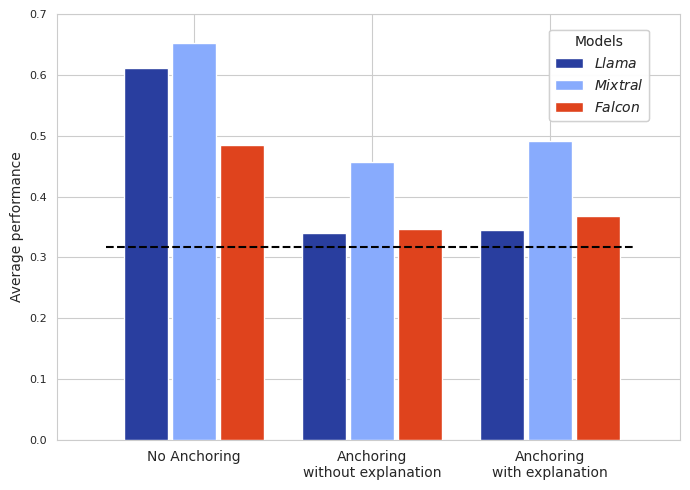

In [457]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)

advocate_levels, include_explanations = ["None", "assistant", "assistant"], [
    False,
    False,
    True,
]

x_points = np.arange(len(advocate_levels))
total_width = 0.75
spacing = 0.02
width = total_width / len(advocate_levels)

for i, model in enumerate(models):
    y_points = np.array(
        [
            np.array(
                [
                    res["performance"]["overall"]
                    for res in results_advocate
                    if res["model"] == model
                    and res["include_explanation"] == include_explanation
                    and res["advocate_level"] == advocate_level
                ]
            ).mean()
            for advocate_level, include_explanation in zip(
                advocate_levels, include_explanations
            )
        ]
    )
    ax.bar(
        x_points + i * width + i * spacing,
        y_points,
        width=width,
        label=model,
        color=model_colors[i],
        zorder=5,
    )

mean_perf = np.mean([RANDOM_PERFORMANCE[dataset_name] for dataset_name in datasets])
ax.plot(
    [-width / 2 - 0.1, len(advocate_levels) - 1 + total_width],
    [mean_perf, mean_perf],
    color="black",
    linestyle="--",
    zorder=10,
)

legend_lines = [mpatches.Patch(facecolor=color, alpha=1) for color in model_colors]
legend_names = [MODEL_NAMES[model] for model in models]
legend = plt.legend(
    legend_lines, legend_names, loc=(0.79, 0.75), ncol=1, fontsize=10, title="Models"
)
ax.add_artist(legend)

ax.set_xlim([-0.5, len(advocate_levels)])
ax.set_xticks(
    x_points + np.mean([i * (width + spacing) for i in range(len(advocate_levels))]),
    ["No Anchoring", "Anchoring\nwithout explanation", "Anchoring\nwith explanation"],
    rotation=0,
    fontsize=10,
)
ax.set_yticks(
    np.arange(0, 0.8, 0.1),
    ["{:.1f}".format(x) for x in np.arange(0, 0.8, 0.1)],
    fontsize=8,
)
ax.set_ylabel("Average performance")
plt.tight_layout()
plt.savefig("figures/average_performance.pdf")
plt.show()

## Check instuction following based on if the explanation is correct

In [7]:
judge_level = "assistant"
advocate_level = "assistant"
additional_syste_prompt = "None"

results_fine = []

for model in models:
    for dataset_name in datasets:
        exp = get_last_exp_by_time(
            data_path, model, dataset_name, additional_syste_prompt
        )

        prob_filename = f"probabilities_{judge_level}_None_False.pkl"
        probabilities = load_pickle(os.path.join(exp, prob_filename))

        dataset_filename = f"dataset_{judge_level}_None_False.pkl"
        dataset = load_pickle(os.path.join(exp, dataset_filename))

        dataset = add_question_idx_in_dataset(dataset)
        question_indices_results_unbiased = get_sample_metrics(
            probabilities=probabilities, dataset=dataset
        )

        for include_explanation in [True, False]:
            prob_filename_bias = f"probabilities_{judge_level}_{advocate_level}_{include_explanation}.pkl"
            probabilities_bias = load_pickle(os.path.join(exp, prob_filename_bias))

            dataset_filename_bias = (
                f"dataset_{judge_level}_{advocate_level}_{include_explanation}.pkl"
            )
            dataset_bias = load_pickle(os.path.join(exp, dataset_filename_bias))

            dataset_bias = add_question_idx_in_dataset(dataset_bias)

            results_fine.append(
                {
                    "dataset": dataset_name,
                    "raw_dataset_bias": dataset_bias,
                    "probabilities_bias": probabilities_bias,
                    "model": model,
                    "include_explanation": include_explanation,
                    "question_indices_results_unbiased": question_indices_results_unbiased,
                    "instuction_following_percentage_wrong_explanation": get_instuction_following_percentage(
                        dataset=dataset_bias,
                        probabilities=probabilities_bias,
                        question_indices=[
                            x["question_idx"]
                            for x in question_indices_results_unbiased
                            if x["result"] == True
                        ],
                        explanation_is_correct=False,
                    ).mean(),
                    "instuction_following_percentage_correct_explanation": get_instuction_following_percentage(
                        dataset=dataset_bias,
                        probabilities=probabilities_bias,
                        question_indices=[
                            x["question_idx"]
                            for x in question_indices_results_unbiased
                            if x["result"] == False
                        ],
                        explanation_is_correct=True,
                    ).mean(),
                }
                | probability_stats(
                    dataset, probabilities, dataset_bias, probabilities_bias
                )
            )

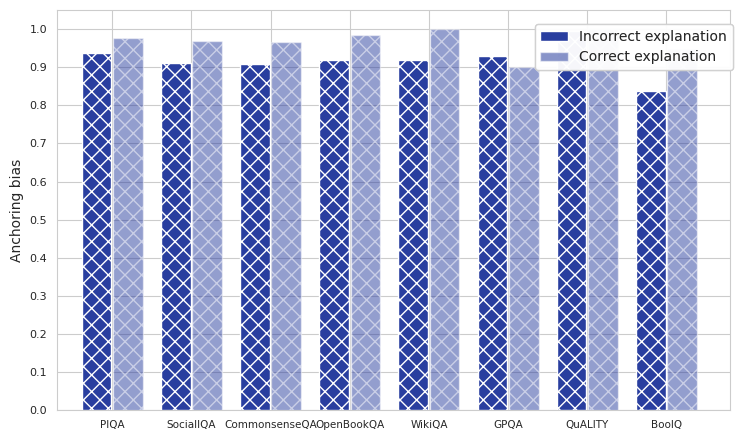

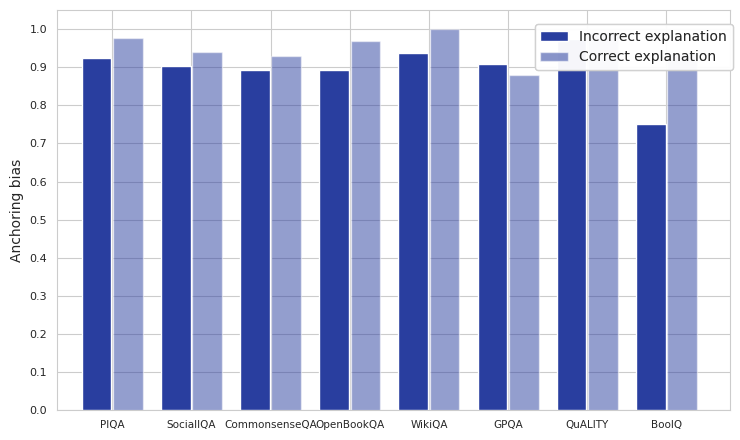

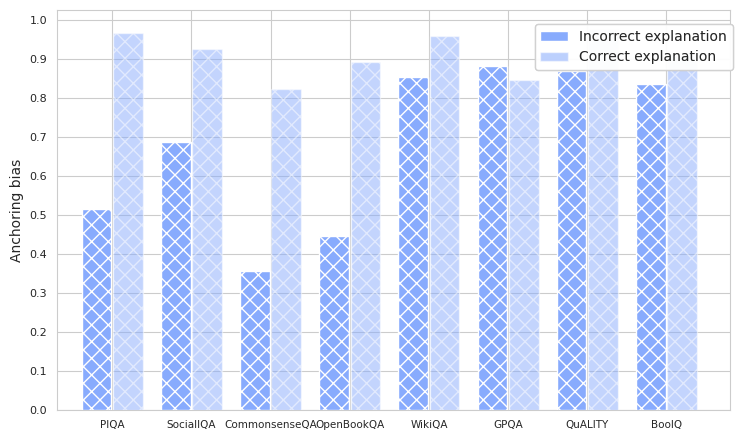

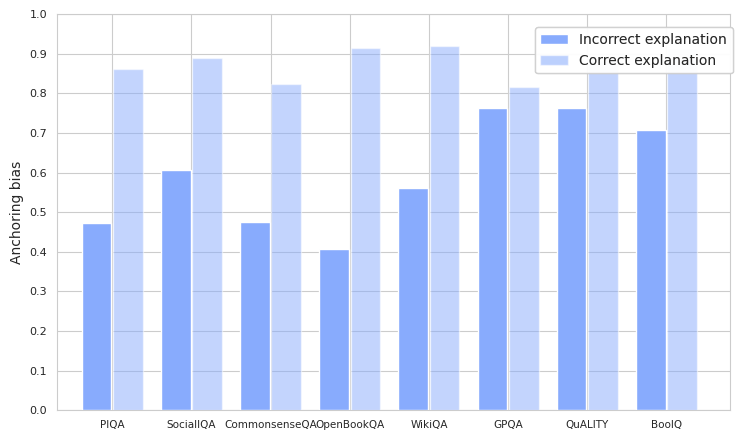

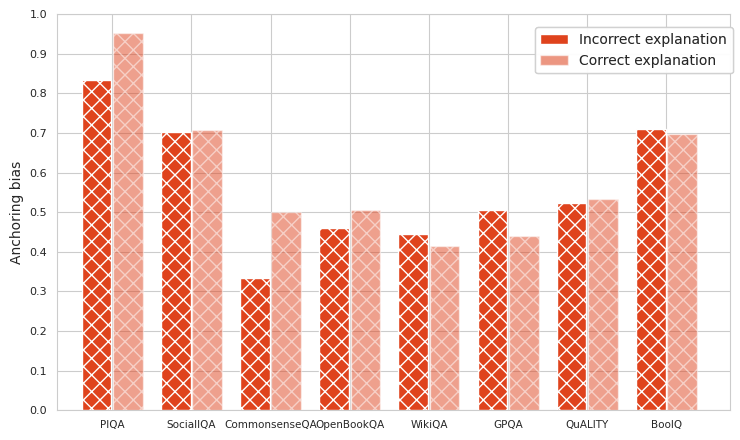

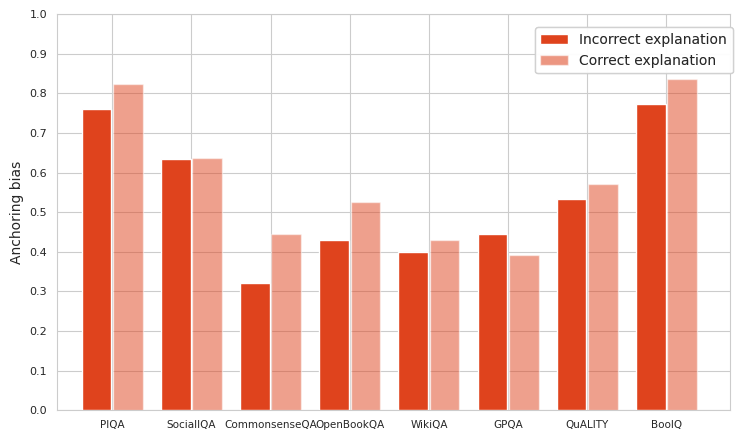

In [18]:
x_points = np.arange(len(datasets))
total_width = 0.75
spacing = 0.02
width = total_width / 2

for model_idx in range(len(models)):
    model = models[model_idx]
    for include_explanation in [False, True]:
        fig = plt.figure(figsize=(7.5, 4.5))
        ax = fig.add_subplot(111)

        for i, mode in enumerate(["wrong", "correct"]):
            y_points_True = np.array(
                [
                    res["instuction_following_percentage_" + mode + "_explanation"]
                    for res in results_fine
                    if res["model"] == model
                    and res["include_explanation"] == include_explanation
                ]
            )
            ax.bar(
                x_points + i * width + i * spacing,
                y_points_True,
                width=width,
                label=model,
                color=model_colors[model_idx],
                zorder=5,
                hatch="XX" if include_explanation == False else None,
                alpha=(0.5 if mode == "correct" else 1.0),
            )

        ax.set_xlim([-0.5, len(datasets)])
        ax.set_xticks(
            x_points + np.mean([i * (width + spacing) for i in range(2)]),
            [DATASET_NAMES[dataset_name] for dataset_name in datasets],
            rotation=0,
            fontsize=7.5,
        )
        ax.set_yticks(
            np.arange(0, 1.1, 0.1),
            ["{:.1f}".format(x) for x in np.arange(0, 1.1, 0.1)],
            fontsize=8,
        )
        ax.set_ylabel("Anchoring bias")

        legend_lines = [
            mpatches.Patch(facecolor=model_colors[model_idx], alpha=1.0),
            mpatches.Patch(facecolor=model_colors[model_idx], alpha=0.5),
        ]
        legend_names = ["Incorrect explanation", "Correct explanation"]
        legend = plt.legend(
            legend_lines,
            legend_names,
            loc=(0.71, 0.85),
            ncol=1,
            fontsize=10,
        )
        ax.add_artist(legend)

        plt.tight_layout()
        plt.savefig(
            "figures/anchoring_per_answer_type_{}_{}.pdf".format(
                model, include_explanation
            )
        )
        plt.show()

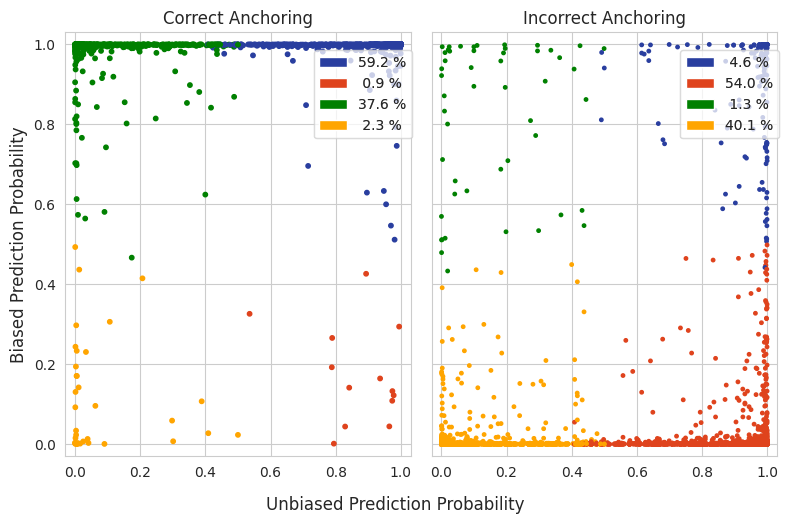

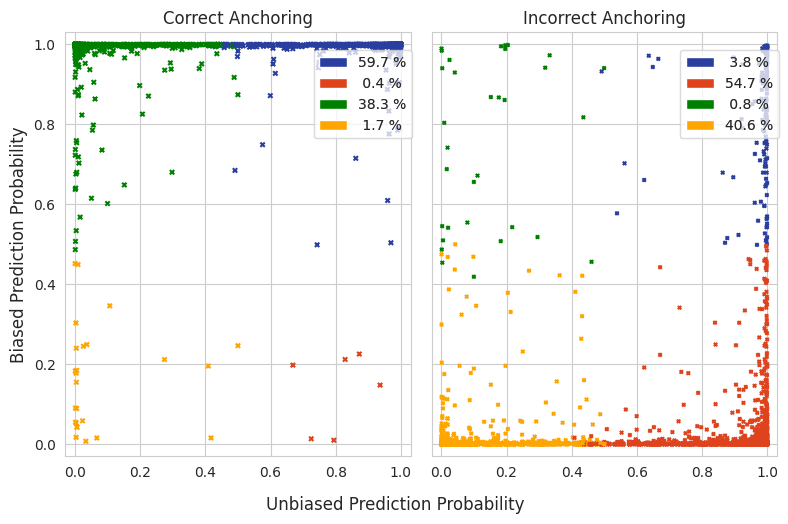

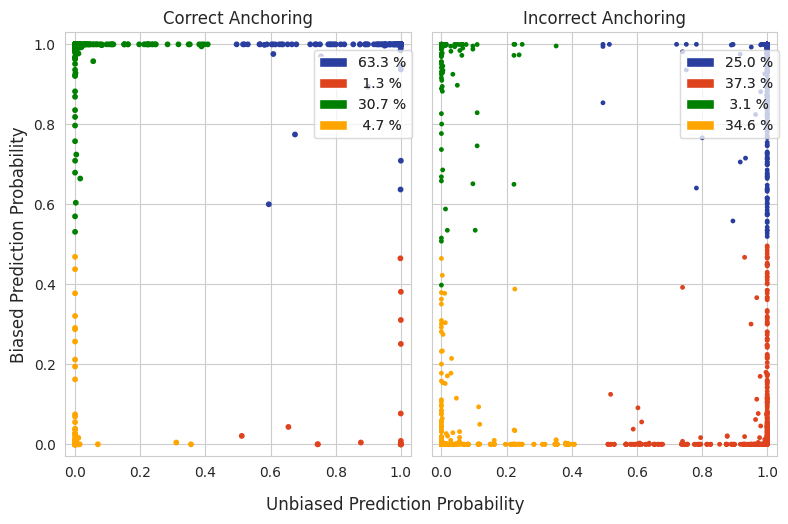

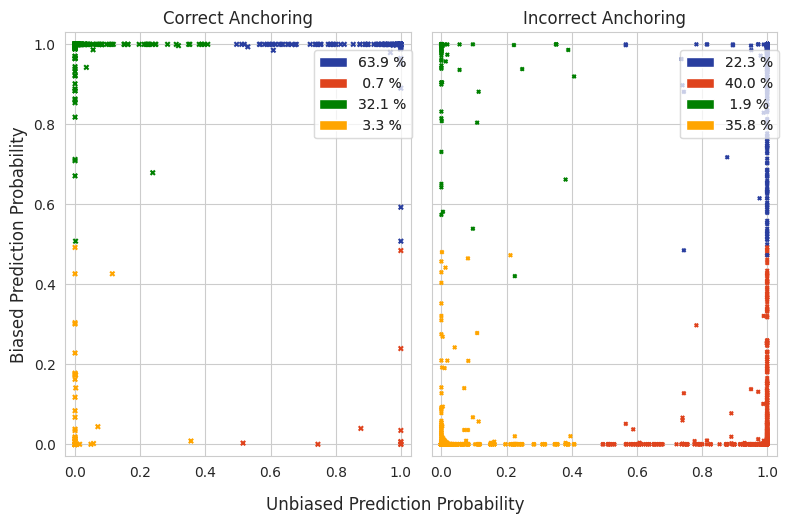

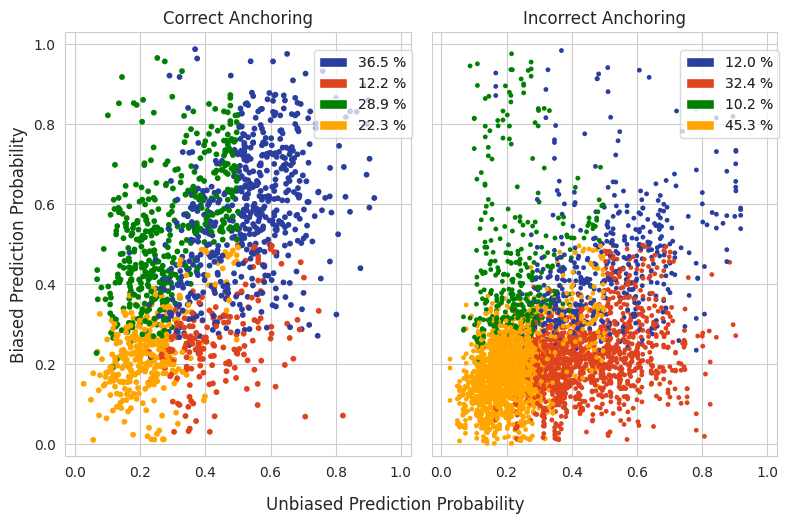

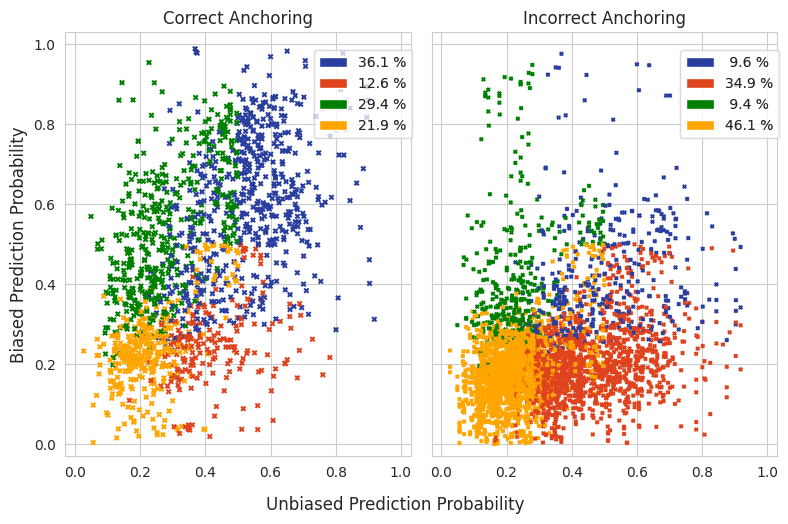

In [15]:
sizes = [10, 6]

myblue = "#293e9f"
myred = "#df431d"

for model in models:
    for include_explanation in [True, False]:
        fig, axes = plt.subplots(figsize=(8, 5), sharey=True, ncols=2)
        ax1, ax2 = axes

        def get_color(x, y):
            if x and y:
                return myblue
            if not x and y:
                return "green"
            if x and not y:
                return myred
            if not x and not y:
                return "orange"

        counting = [{myblue: 0, myred: 0, "green": 0, "orange": 0} for _ in range(2)]

        for dataset_name in datasets:
            res = [
                res
                for res in results_fine
                if res["model"] == model
                and res["include_explanation"] == include_explanation
                and res["dataset"] == dataset_name
            ][0]

            is_original_correct = res["is_original_correct"]
            is_bias_correct = res["is_bias_correct"]
            is_explanation_correct = res["is_explanation_correct"]
            prob_original_correct = res["prob_original_correct"]
            prob_bias_correct = res["prob_bias_correct"]

            colors = [
                get_color(x, y)
                for x, y in zip(
                    is_original_correct[is_explanation_correct],
                    is_bias_correct[is_explanation_correct],
                )
            ]
            color, count = np.unique(colors, return_counts=True)
            counting[0] = {
                k: (count[list(color).index(k)] if k in color else 0) + counting[0][k]
                for k, v in counting[0].items()
            }

            ax1.scatter(
                prob_original_correct[is_explanation_correct],
                prob_bias_correct[is_explanation_correct],
                color=colors,
                s=sizes[0],
                marker="x" if not include_explanation else "o",
            )

            colors = [
                get_color(x, y)
                for x, y in zip(
                    is_original_correct[~is_explanation_correct],
                    is_bias_correct[~is_explanation_correct],
                )
            ]
            color, count = np.unique(colors, return_counts=True)
            counting[1] = {
                k: (count[list(color).index(k)] if k in color else 0) + counting[1][k]
                for k, v in counting[1].items()
            }

            ax2.scatter(
                prob_original_correct[~is_explanation_correct],
                prob_bias_correct[~is_explanation_correct],
                color=colors,
                s=sizes[1],
                marker="x" if not include_explanation else "o",
            )

        for ax in [ax1, ax2]:
            ax.set_xlim([-0.03, 1.03])
            ax.set_ylim([-0.03, 1.03])

        # Add global xlabel
        fig.text(
            0.5,
            -0.02,
            "Unbiased Prediction Probability",
            ha="center",
            va="center",
            fontsize=12,
        )
        ax1.set_ylabel("Biased Prediction Probability", fontsize=12)

        legend_lines = [
            mpatches.Patch(facecolor=color, alpha=1) for color in counting[0]
        ]
        legend_names = [
            ("{:.1f}".format(100 * v / np.sum(list(counting[0].values())))).rjust(
                4, " "
            )
            + " %"
            for v in counting[0].values()
        ]
        legend = ax1.legend(
            legend_lines,
            legend_names,
            loc=(0.72, 0.75),
            ncol=1,
            fontsize=10,
            framealpha=0.5,
        )
        ax1.add_artist(legend)

        legend_names = [
            ("{:.1f}".format(100 * v / np.sum(list(counting[1].values())))).rjust(
                4, " "
            )
            + " %"
            for v in counting[1].values()
        ]
        legend = ax2.legend(
            legend_lines,
            legend_names,
            loc=(0.72, 0.75),
            ncol=1,
            fontsize=10,
            framealpha=0.5,
        )
        ax2.add_artist(legend)

        ax1.set_title("Correct Anchoring")
        ax2.set_title("Incorrect Anchoring")

        biasing = [
            {k: v / np.sum(list(c.values())) for k, v in c.items()} for c in counting
        ]
        plt.tight_layout()

        plt.savefig(f"figures/biasing_{model}_{include_explanation}.pdf")
        plt.show()

## Calibration in other ways .. ?

In [16]:
model = models[2]
include_explanation = False
dataset_name = datasets[0]

res = [
    res
    for res in results_fine
    if res["model"] == model
    and res["include_explanation"] == include_explanation
    and res["dataset"] == dataset_name
][0]

is_original_correct = res["is_original_correct"]
is_bias_correct = res["is_bias_correct"]
is_explanation_correct = res["is_explanation_correct"]
prob_original_correct = res["prob_original_correct"]
prob_bias_correct = res["prob_bias_correct"]

mask = np.logical_and(is_original_correct, is_explanation_correct)

## Test

## Check calibration?